In [2]:
import sys
sys.path.append('../..')
sys.path.append('../data')
sys.path.append('../../helper_code')

from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import numpy as np
import pandas as pd
from IPython.display import display
import copy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from helper_code.custom_kernel import *

In [38]:
# Load Data

X = pd.read_csv('../data/benzene_training_data/[Benz] ANM_X.csv')
X_inv = pd.read_csv('../data/benzene_training_data/[Benz] ANM_X_inv.csv')
X_lexi = pd.read_csv('../data/benzene_training_data/[Benz] ANM_X_lexi.csv')
X_lexi_nd = pd.read_csv('../data/benzene_training_data/[Benz] ANM_X_lexi_nd.csv')
X_sorted = pd.read_csv('../data/benzene_training_data/[Benz] ANM_X_sorted.csv')
X_coulomb = pd.read_csv('../data/benzene_training_data/[Benz] ANM_X_coulomb.csv')

X_square_eig = pd.read_csv("../data/benzene_training_data/[Benz] ANM_X_square_eig.csv")
X_inv_square_eig = pd.read_csv("../data/benzene_training_data/[Benz] ANM_X_inv_square_eig.csv")
X_lexi_square_eig = pd.read_csv("../data/benzene_training_data/[Benz] ANM_X_lexi_square_eig.csv")
X_lexi_inv_square_eig = pd.read_csv("../data/benzene_training_data/[Benz] ANM_X_lexi_inv_square_eig.csv")

inv_dist_X = pd.read_csv('../data/benzene_training_data/[Benz] inv_dist_X.csv')
inv_dist_X_lexi = pd.read_csv('../data/benzene_training_data/[Benz] inv_dist_X_lexi.csv')
inv_dist_X_lexi_nd = pd.read_csv('../data/benzene_training_data/[Benz] inv_dist_X_lexi_nd.csv')
inv_dist_X_sorted = pd.read_csv('../data/benzene_training_data/[Benz] inv_dist_X_sorted.csv')
inv_dist_X_coulomb = pd.read_csv('../data/benzene_training_data/[Benz] inv_dist_X_coulomb.csv')
inv_dist_X_lexi_inv_square_eig = pd.read_csv('../data/benzene_training_data/[Benz] inv_dist_X_lexi_inv_square_eig.csv')


rand_X = pd.read_csv('../data/benzene_training_data/[Benz] rand_X.csv')
rand_X_lexi = pd.read_csv('../data/benzene_training_data/[Benz] rand_X_lexi.csv')
rand_X_lexi_nd = pd.read_csv('../data/benzene_training_data/[Benz] rand_X_lexi_nd.csv')
rand_X_sorted = pd.read_csv('../data/benzene_training_data/[Benz] rand_X_sorted.csv')
rand_X_coulomb = pd.read_csv('../data/benzene_training_data/[Benz] rand_X_coulomb.csv')
rand_X_lexi_inv_square_eig = pd.read_csv('../data/benzene_training_data/[Benz] rand_X_lexi_inv_square_eig.csv')

y_energy = pd.read_csv("../data/benzene_training_data/[Benz] y_energy.csv")
y_elec = pd.read_csv("../data/benzene_training_data/[Benz] y_elec.csv")
y_delta_elec = pd.read_csv("../data/benzene_training_data/[Benz] y_delta_elec.csv")
y_delta_energy = pd.read_csv("../data/benzene_training_data/[Benz] y_delta_energy.csv")

y_delta_delta = pd.read_csv("../data/benzene_training_data/[Benz] y_delta_delta_ANM.csv")

In [4]:
def evaluate_performance(model, X, y, num_training_sample, num_trials):

    """ 
    Given the number of training samples used, 
    calculate the average and standard deviation of MSE across a certain number of trials.
    For each trial, a specified number of training examples is used to train the model, 
    which is then evaluated on the rest of the data set.

    Args:
        X (ndarray): training data; size (N, m) where N is the number of training examples and m is the number of features
        y (ndarray): target data; size (N, 1)
        num_training_sample (int): the number of samples used for training
        num_trials: the number of trials 
    
    Returns:
        average_error: the average MSE across all trials
        std_dev_error: standard deviation of the error across all trials
    """

    errors = []
    test_size = 1.0 - num_training_sample/X.shape[0]

    for i in range(num_trials):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        error = mean_absolute_error(y_val, y_pred) 
        errors.append(error)
    
    average_error = np.mean(errors)
    std_dev_error = np.std(errors)/np.sqrt(num_trials)
    return average_error, std_dev_error

In [5]:
def evaluate_performance_custom_kernel(model, X, y, num_training_sample, num_trials, similarity_kernel, params):
    """ 
    Given the number of training samples used, 
    calculate the average and standard deviation of MSE across a certain number of trials.
    For each trial, a specified number of training examples is used to train the model, 
    which is then evaluated on the rest of the data set.

    Args:
        X (ndarray): training data; size (N, m) where N is the number of training examples and m is the number of features
        y (ndarray): target data; size (N, 1)
        num_training_sample (int): the number of samples used for training
        num_trials: the number of trials 
        similarity_kernel: the custom kernel used
    
    Returns:
        average_error: the average MSE across all trials
        std_dev_error: standard deviation of the error across all trials
    """

    errors = []
    test_size = 1.0 - num_training_sample/X.shape[0]

    for i in range(num_trials):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=42+i)
        X_train = X_train.to_numpy()
        y_train = y_train.to_numpy()
        X_val = X_val.to_numpy()
        y_val = y_val.to_numpy()

        similarity_matrix = create_similarity_matrix(X_train, X_train, similarity_kernel, params)
        model.fit(similarity_matrix, y_train)
        prediction_matrix = create_similarity_matrix(X_train, X_val, similarity_kernel, params)
        y_pred = model.predict(prediction_matrix)
        error = mean_absolute_error(y_val, y_pred) 
        errors.append(error)
    
    average_error = np.mean(errors)
    std_dev_error = np.std(errors)/np.sqrt(num_trials)
    return average_error, std_dev_error

## Ordinary Gaussian Kernel ##

### Vanilla ###

In [6]:
# model_gaussian

best_params = {'alpha': 1e-17, 'gamma': 2e-07, 'kernel': 'rbf'}
model_gaussian = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_gaussian = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_gaussian, X, y_delta_energy, num_training_sample, num_trials)
        model_performance_gaussian.at[index, 'training size'] = num_training_sample
        model_performance_gaussian.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_gaussian.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_gaussian)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,2030.039751,136.552925
2,4,2534.616037,296.4471
3,8,1906.887173,146.451173
4,16,806.124936,161.388261


In [7]:
# model_gaussian

best_params = {'alpha': 1e-17, 'gamma': 2e-07, 'kernel': 'rbf'}
model_gaussian_elec = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_gaussian_elec = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_gaussian_elec, X, y_delta_elec, num_training_sample, num_trials)
        model_performance_gaussian_elec.at[index, 'training size'] = num_training_sample
        model_performance_gaussian_elec.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_gaussian_elec.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_gaussian_elec)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,1969.794441,121.067344
2,4,2426.320507,278.52687
3,8,1846.13098,141.497672
4,16,828.45236,157.309733


### Lexi Representation ###

In [8]:
# model_gaussian_lexi

best_params = {'alpha': 1e-17, 'gamma': 2e-07, 'kernel': 'rbf'}
model_gaussian_lexi = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_gaussian_lexi = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_gaussian_lexi, X_lexi, y_delta_energy, num_training_sample, num_trials)
        model_performance_gaussian_lexi.at[index, 'training size'] = num_training_sample
        model_performance_gaussian_lexi.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_gaussian_lexi.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_gaussian_lexi)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,2070.368525,133.672151
2,4,3015.499012,315.183767
3,8,2228.600255,247.674129
4,16,255.632713,158.132883


In [9]:
# model_gaussian_lexi

best_params = {'alpha': 1e-17, 'gamma': 2e-07, 'kernel': 'rbf'}
model_gaussian_lexi_elec = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_gaussian_lexi_elec = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_gaussian_lexi_elec, X_lexi, y_delta_elec, num_training_sample, num_trials)
        model_performance_gaussian_lexi_elec.at[index, 'training size'] = num_training_sample
        model_performance_gaussian_lexi_elec.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_gaussian_lexi_elec.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_gaussian_lexi_elec)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,2014.274545,126.841352
2,4,2943.008378,304.440018
3,8,2201.696331,237.837903
4,16,249.45114,156.779788


### Sorted dx ###

In [10]:
# Gaussian_sorted

best_params = {'alpha': 3e-7, 'gamma': 0.00323, 'kernel': 'rbf'}
model_gaussian_sorted = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_gaussian_sorted = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_gaussian_sorted, X_sorted, y_delta_energy, num_training_sample, num_trials)
        model_performance_gaussian_sorted.at[index, 'training size'] = num_training_sample
        model_performance_gaussian_sorted.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_gaussian_sorted.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_gaussian_sorted)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,759.343267,128.067289
2,4,714.808855,151.704796
3,8,208.333539,96.350765
4,16,83.043946,12.576356


In [11]:
# Gaussian_sorted_elec

best_params = {'alpha': 3e-7, 'gamma': 0.00323, 'kernel': 'rbf'}
model_gaussian_sorted_elec = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_gaussian_sorted_elec = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_gaussian_sorted_elec, X_sorted, y_delta_elec, num_training_sample, num_trials)
        model_performance_gaussian_sorted_elec.at[index, 'training size'] = num_training_sample
        model_performance_gaussian_sorted_elec.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_gaussian_sorted_elec.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_gaussian_sorted_elec)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,884.591993,95.097924
2,4,796.919383,121.980785
3,8,277.185481,76.015028
4,16,151.660657,21.633573


## Extended Gaussian Kernel ##

### Vanilla ###

In [12]:
# model_ex_gaussian

best_params = {'gamma': 4e-10, 'epsilon': 0.0004, 'beta': 2.333333333333333e-07, 'alpha': 1e-15}

model_ex_gaussian = KernelRidge(kernel='precomputed', alpha=best_params['alpha'])

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_ex_gaussian = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance_custom_kernel(model_ex_gaussian, X, y_delta_energy, num_training_sample, num_trials, extended_gaussian_kernel, best_params)
        model_performance_ex_gaussian.at[index, 'training size'] = num_training_sample
        model_performance_ex_gaussian.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_ex_gaussian.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_ex_gaussian)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,739.090273,116.97735
2,4,688.587457,145.05896
3,8,133.302431,27.388632
4,16,48.150074,4.924789


In [13]:
# model_ex_gaussian_elec

best_params = {'gamma': 4e-10, 'epsilon': 0.0004, 'beta': 2.333333333333333e-07, 'alpha': 1e-15}

model_ex_gaussian_elec = KernelRidge(kernel='precomputed', alpha=best_params['alpha'])

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_ex_gaussian_elec = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance_custom_kernel(model_ex_gaussian_elec, X, y_delta_elec, num_training_sample, num_trials, extended_gaussian_kernel, best_params)
        model_performance_ex_gaussian_elec.at[index, 'training size'] = num_training_sample
        model_performance_ex_gaussian_elec.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_ex_gaussian_elec.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_ex_gaussian_elec)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,723.103474,119.835256
2,4,693.882702,141.164474
3,8,175.621623,19.939948
4,16,88.622748,9.045974


### Lexi Representation ###

In [36]:
# model_ex_gaussian_lexi

best_params = {'gamma': 4e-10, 'epsilon': 0.0004, 'beta': 2.333333333333333e-07, 'alpha': 1e-15}

model_ex_gaussian_lexi = KernelRidge(kernel='precomputed', alpha=best_params['alpha'])

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_ex_gaussian_lexi = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance_custom_kernel(model_ex_gaussian_lexi, X_lexi, y_delta_energy, num_training_sample, num_trials, extended_gaussian_kernel, best_params)
        model_performance_ex_gaussian_lexi.at[index, 'training size'] = num_training_sample
        model_performance_ex_gaussian_lexi.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_ex_gaussian_lexi.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_ex_gaussian_lexi)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,737.552228,116.542591
2,4,692.015333,144.38982
3,8,127.916429,27.491299
4,16,29.207403,4.374063


In [15]:
# model_ex_gaussian_lexi_elec

best_params = {'gamma': 4e-10, 'epsilon': 0.0004, 'beta': 2.333333333333333e-07, 'alpha': 1e-15}

model_ex_gaussian_lexi_elec = KernelRidge(kernel='precomputed', alpha=best_params['alpha'])

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_ex_gaussian_lexi_elec = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance_custom_kernel(model_ex_gaussian_lexi_elec, X_lexi, y_delta_elec, num_training_sample, num_trials, extended_gaussian_kernel, best_params)
        model_performance_ex_gaussian_lexi_elec.at[index, 'training size'] = num_training_sample
        model_performance_ex_gaussian_lexi_elec.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_ex_gaussian_lexi_elec.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_ex_gaussian_lexi_elec)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,722.773787,119.734337
2,4,693.670671,141.568332
3,8,150.396112,19.652937
4,16,76.012587,8.628704


## Coefficient Squared Eigen ##

### Ordinary Gaussian ###

In [24]:
# model_gaussian

best_params = {'alpha': 3.346938775510204e-16, 'gamma': 2.7142857142857142e-12, 'kernel': 'rbf'}
model_CSE_gaussian = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_CSE_gaussian = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_CSE_gaussian, X_lexi_inv_square_eig, y_delta_energy, num_training_sample, num_trials)
        model_performance_CSE_gaussian.at[index, 'training size'] = num_training_sample
        model_performance_CSE_gaussian.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_CSE_gaussian.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_CSE_gaussian)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,1948.638043,132.772329
2,4,1876.298175,110.455741
3,8,35.987417,3.772873
4,16,22.513409,2.680986


### Extended Gaussian ###

In [26]:
best_params = {'gamma': 2.3e-08, 'epsilon': 5e-13, 'beta': 9.25e-07, 'alpha': 3.85e-08}

model_CSE_ex_gaussian = KernelRidge(kernel='precomputed', alpha=best_params['alpha'])

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_CSE_ex_gaussian = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance_custom_kernel(model_CSE_ex_gaussian, X_lexi_inv_square_eig, y_delta_energy, num_training_sample, num_trials, extended_gaussian_kernel, best_params)
        model_performance_CSE_ex_gaussian.at[index, 'training size'] = num_training_sample
        model_performance_CSE_ex_gaussian.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_CSE_ex_gaussian.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_CSE_ex_gaussian)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,2178.668751,163.025671
2,4,2034.09493,135.469095
3,8,69.854211,13.790357
4,16,22.204989,2.411479


## Delta Learning ##

### Ordinary Gaussian ###

In [39]:
best_params = {'alpha': 2.612244897959184e-05, 'gamma': 2.9693877551020406e-07, 'kernel': 'rbf'}
model_delta_gaussian = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_delta_gaussian = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_delta_gaussian, X_lexi_inv_square_eig, y_delta_delta, num_training_sample, num_trials)
        model_performance_delta_gaussian.at[index, 'training size'] = num_training_sample
        model_performance_delta_gaussian.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_delta_gaussian.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_delta_gaussian)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,150.708604,5.910511
2,4,125.857392,8.824039
3,8,33.849822,3.379003
4,16,18.624072,2.024536


### Extended Gaussian ###

In [41]:
best_params = {'gamma': 2.3e-08, 'epsilon': 5e-13, 'beta': 9.25e-07, 'alpha': 3.85e-08}

model_delta_ex_gaussian = KernelRidge(kernel='precomputed', alpha=best_params['alpha'])

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_delta_ex_gaussian = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance_custom_kernel(model_delta_ex_gaussian, X_lexi_inv_square_eig, y_delta_delta, num_training_sample, num_trials, extended_gaussian_kernel, best_params)
        model_performance_delta_ex_gaussian.at[index, 'training size'] = num_training_sample
        model_performance_delta_ex_gaussian.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_delta_ex_gaussian.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_delta_ex_gaussian)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,161.50904,9.308163
2,4,154.286304,10.23489
3,8,32.602444,4.272533
4,16,20.19479,1.946353


## Inverse Distance Matrix ##

### Extended Kernel ###

In [32]:
# model_inv_dist_ex_gaussian_lexi

best_params = {'gamma': 4e-10, 'epsilon': 0.0004, 'beta': 2.333333333333333e-07, 'alpha': 1e-15}

model_inv_dist_ex_gaussian_lexi = KernelRidge(kernel='precomputed', alpha=best_params['alpha'])

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_inv_dist_ex_gaussian_lexi = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance_custom_kernel(model_inv_dist_ex_gaussian_lexi, inv_dist_X_lexi, y_delta_energy, num_training_sample, num_trials, extended_gaussian_kernel, best_params)
        model_performance_inv_dist_ex_gaussian_lexi.at[index, 'training size'] = num_training_sample
        model_performance_inv_dist_ex_gaussian_lexi.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_inv_dist_ex_gaussian_lexi.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_inv_dist_ex_gaussian_lexi)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,737.552231,116.542591
2,4,692.015345,144.389823
3,8,127.916429,27.491299
4,16,29.211462,4.374879


### Coefficient Squared Eigen ###

In [32]:
best_params = {'alpha': 3.346938775510204e-16, 'gamma': 2.7142857142857142e-12, 'kernel': 'rbf'}
model_inv_dist_CSE_gaussian = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_inv_dist_CSE_gaussian = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_inv_dist_CSE_gaussian, inv_dist_X_lexi_inv_square_eig, y_delta_energy, num_training_sample, num_trials)
        model_performance_inv_dist_CSE_gaussian.at[index, 'training size'] = num_training_sample
        model_performance_inv_dist_CSE_gaussian.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_inv_dist_CSE_gaussian.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_inv_dist_CSE_gaussian)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,1992.916318,146.35253
2,4,1798.119612,169.6907
3,8,29.442176,4.199702
4,16,18.296542,1.881828


In [37]:
best_params = {'gamma': 2.3e-08, 'epsilon': 5e-13, 'beta': 9.25e-07, 'alpha': 3.85e-08}

model_inv_dist_CSE_ex_gaussian = KernelRidge(kernel='precomputed', alpha=best_params['alpha'])

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_model_inv_dist_CSE_ex_gaussian = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance_custom_kernel(model_inv_dist_CSE_ex_gaussian, inv_dist_X_lexi_inv_square_eig, y_delta_energy, num_training_sample, num_trials, extended_gaussian_kernel, best_params)
        model_performance_model_inv_dist_CSE_ex_gaussian.at[index, 'training size'] = num_training_sample
        model_performance_model_inv_dist_CSE_ex_gaussian.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_model_inv_dist_CSE_ex_gaussian.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_model_inv_dist_CSE_ex_gaussian)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,2243.12301,173.129479
2,4,2032.662096,134.687537
3,8,73.009104,38.52929
4,16,28.74282,2.269346


### Delta Learning ###

In [40]:
best_params = {'alpha': 3.346938775510204e-16, 'gamma': 2.7142857142857142e-12, 'kernel': 'rbf'}
model_inv_dist_delta_gaussian = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_inv_dist_delta_gaussian = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_inv_dist_delta_gaussian, inv_dist_X_lexi_inv_square_eig, y_delta_delta, num_training_sample, num_trials)
        model_performance_inv_dist_delta_gaussian.at[index, 'training size'] = num_training_sample
        model_performance_inv_dist_delta_gaussian.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_inv_dist_delta_gaussian.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_inv_dist_delta_gaussian)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,155.052694,5.936246
2,4,145.05972,8.99038
3,8,48.023624,6.021162
4,16,33.566092,2.383376


## Random Matrix Projection ##

### Coefficient Squared Eigen ###

In [34]:
best_params = {'alpha': 3.346938775510204e-16, 'gamma': 2.7142857142857142e-12, 'kernel': 'rbf'}
model_rand_CSE_gaussian = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_rand_CSE_gaussian = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_rand_CSE_gaussian, rand_X_lexi_inv_square_eig, y_delta_energy, num_training_sample, num_trials)
        model_performance_rand_CSE_gaussian.at[index, 'training size'] = num_training_sample
        model_performance_rand_CSE_gaussian.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_rand_CSE_gaussian.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_rand_CSE_gaussian)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,1959.064923,165.07211
2,4,3128.503863,515.679221
3,8,379.684263,100.115619
4,16,42.2738,4.542546


## Learning Curve ##

### Comparing All Models ###

In [25]:
# Baseline model

ntrain = [2,4,8]
fchl19 = [0.27527329, 0.23115197, 0.00571815]
mbdf = [0.28018813 ,0.17915239 ,0.00936729]

fchl19_mHa = [x * 1000 for x in fchl19]
mbdf_mHa = [x * 1000 for x in mbdf]

baseline_performance = {'training size': ntrain,
                        'fchl19': fchl19_mHa,
                        'mbdf': mbdf_mHa}

baseline = pd.DataFrame(baseline_performance)
display(baseline)

,training size,fchl19,mbdf
0,2,275.27329,280.18813
1,4,231.15197,179.15239
2,8,5.71815,9.36729


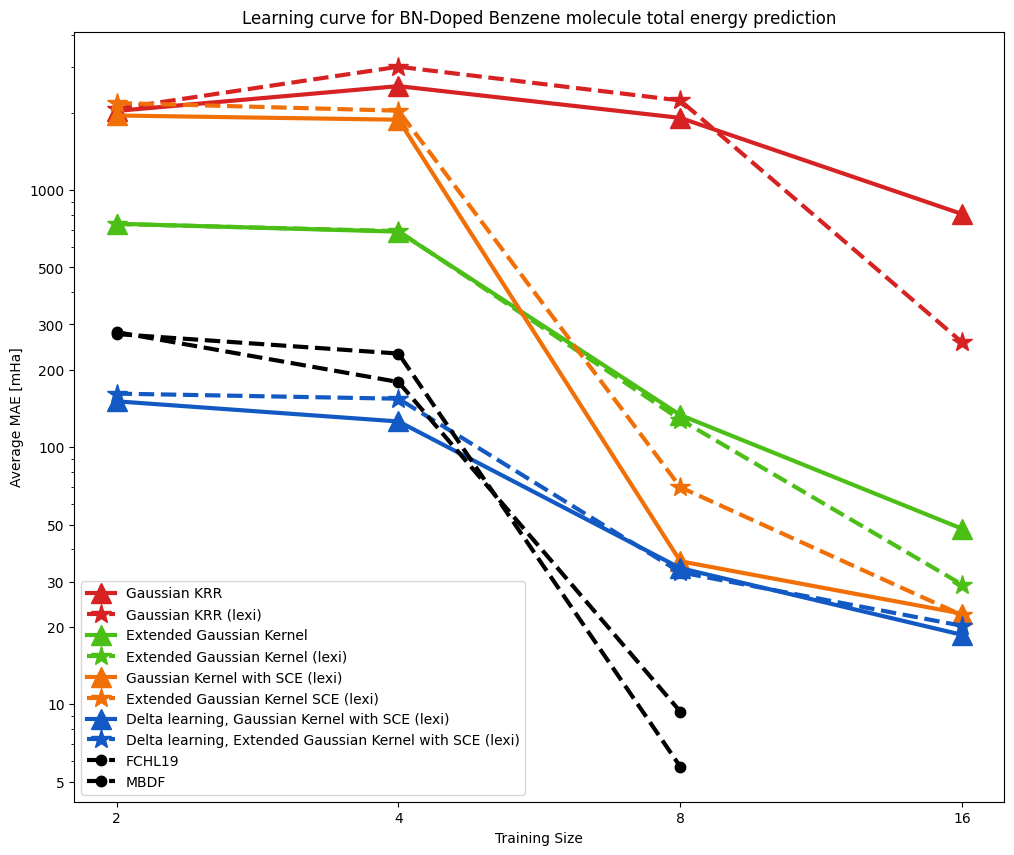

In [51]:
# Set figure size
plt.figure(figsize=(12, 10))

# Load the data
x = model_performance_gaussian['training size']
reduced_x = baseline['training size']

y1 = model_performance_gaussian['average MAE (mHa)']
y2 = model_performance_gaussian_lexi['average MAE (mHa)']
# y3 = model_performance_gaussian_sorted['average MAE (mHa)']

y4 = model_performance_ex_gaussian['average MAE (mHa)']
y5 = model_performance_ex_gaussian_lexi['average MAE (mHa)']

y6 = model_performance_CSE_gaussian['average MAE (mHa)']
y7 = model_performance_CSE_ex_gaussian['average MAE (mHa)']

y8 = model_performance_delta_gaussian['average MAE (mHa)']
y9 = model_performance_delta_ex_gaussian['average MAE (mHa)']

y98 = baseline['fchl19']
y99 = baseline['mbdf']
y100 = [50, 50, 50, 50]

# Plotting
linewidth = 3
markersize = 15

plt.plot(x, y1, label='Gaussian KRR', marker='^', linestyle='-', linewidth=linewidth, markersize=markersize, color='#d62222')
plt.plot(x, y2, label='Gaussian KRR (lexi)', marker='*', linestyle='--', linewidth=linewidth, markersize=markersize, color='#d62222')
# plt.plot(x, y3, label='Gaussian KRR (sorted)', marker='^', linestyle='-', linewidth=linewidth, markersize=markersize)

plt.plot(x, y4, label='Extended Gaussian Kernel', marker='^', linestyle='-', linewidth=linewidth, markersize=markersize, color='#4cbf17')
plt.plot(x, y5, label='Extended Gaussian Kernel (lexi)', marker='*', linestyle='--', linewidth=linewidth, markersize=markersize, color='#4cbf17')

plt.plot(x, y6, label='Gaussian Kernel with SCE (lexi)', marker='^', linestyle='-', linewidth=linewidth, markersize=markersize, color='#f07007')
plt.plot(x, y7, label='Extended Gaussian Kernel SCE (lexi)', marker='*', linestyle='--', linewidth=linewidth, markersize=markersize, color='#f07007')

plt.plot(x, y8, label='Delta learning, Gaussian Kernel with SCE (lexi)', marker='^', linestyle='-', linewidth=linewidth, markersize=markersize, color='#1259c4')
plt.plot(x, y9, label='Delta learning, Extended Gaussian Kernel with SCE (lexi)', marker='*', linestyle='--', linewidth=linewidth, markersize=markersize, color='#1259c4')

plt.plot()

plt.plot(reduced_x, y98, label='FCHL19', marker='.', linestyle='--', linewidth=linewidth, markersize=markersize, color="black")
plt.plot(reduced_x, y99, label='MBDF', marker='.', linestyle='--', linewidth=linewidth, markersize=markersize, color="black")
# plt.plot(x, y100, label='Second Order Taylor Expansion', marker='.', linestyle='-', linewidth=2.5, markersize=0, color='blue')


# Customize the plot
plt.title('Learning curve for BN-Doped Benzene molecule total energy prediction')
plt.xlabel('Training Size')
plt.ylabel('Average MAE [mHa]')
plt.legend()

# Create log scale
plt.xscale('log', base=2)
plt.yscale('log', base=10)

xticks = [2**i for i in range(1, 5)]
# yticks = [10**i for i in range(1, 4)]
yticks = [5, 10, 20, 30, 50, 100, 200, 300, 500, 1000]
plt.xticks(xticks, labels = xticks)
plt.yticks(yticks, labels = yticks)


# Display the plot
plt.savefig('../graph/[Benz] [5.0] [all] Learning curve for BN-Doped Benzene molecule total energy prediction.png', dpi=300)
plt.show()

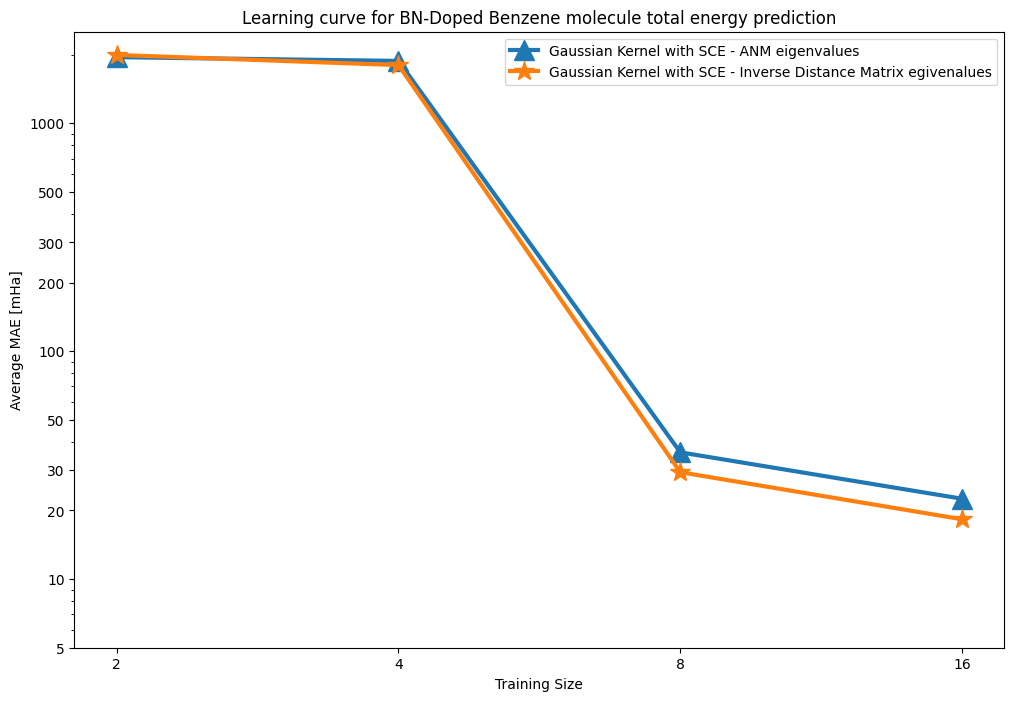

In [55]:
# Set figure size
plt.figure(figsize=(12, 8))

# Load the data
x = model_performance_gaussian['training size']

y6 = model_performance_CSE_gaussian['average MAE (mHa)']
y7 = model_performance_inv_dist_CSE_gaussian['average MAE (mHa)']

y98 = baseline['fchl19']
y99 = baseline['mbdf']
y100 = [50, 50, 50, 50]

# Plotting
linewidth = 3
markersize = 15


plt.plot(x, y6, label='Gaussian Kernel with SCE - ANM eigenvalues', marker='^', linestyle='-', linewidth=linewidth, markersize=markersize)
plt.plot(x, y7, label='Gaussian Kernel with SCE - Inverse Distance Matrix egivenalues', marker='*', linestyle='-', linewidth=linewidth, markersize=markersize)


# Customize the plot
plt.title('Learning curve for BN-Doped Benzene molecule total energy prediction')
plt.xlabel('Training Size')
plt.ylabel('Average MAE [mHa]')
plt.legend()

# Create log scale
plt.xscale('log', base=2)
plt.yscale('log', base=10)

xticks = [2**i for i in range(1, 5)]
# yticks = [10**i for i in range(1, 4)]
yticks = [5, 10, 20, 30, 50, 100, 200, 300, 500, 1000]
plt.xticks(xticks, labels = xticks)
plt.yticks(yticks, labels = yticks)


# Display the plot
plt.savefig('../graph/[Benz] [5.0] Learning curve for ANM vs. IDM.png', dpi=300)
plt.show()

### Comparing total vs electronic energy ###

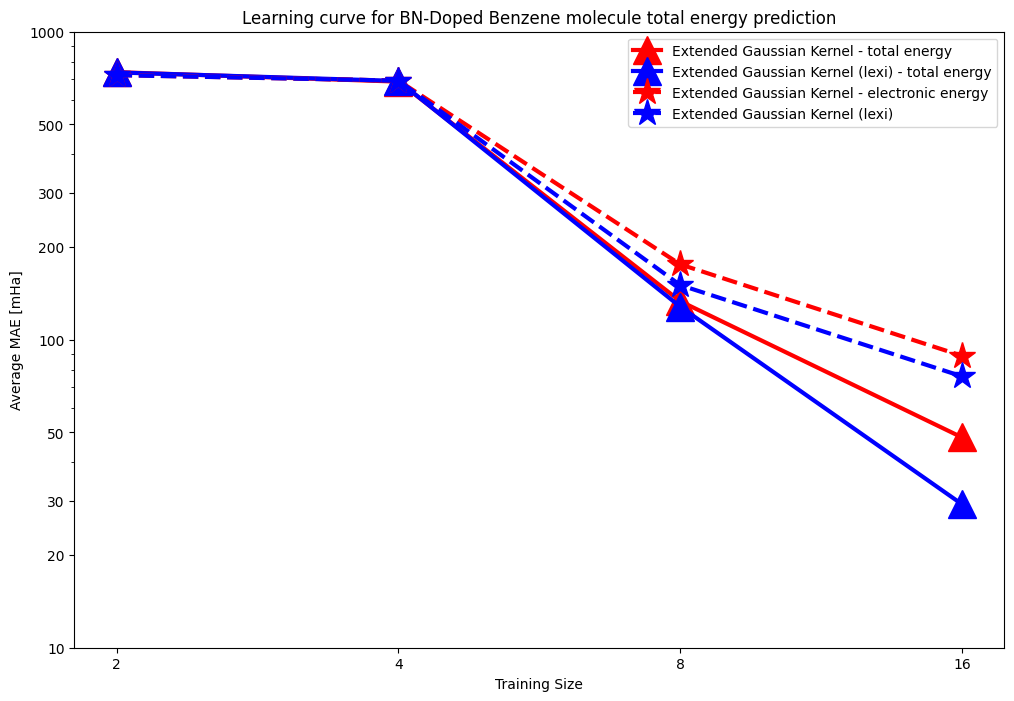

In [36]:
# Set figure size
plt.figure(figsize=(12, 8))

# Load the data
x = model_performance_gaussian['training size']

y4 = model_performance_ex_gaussian['average MAE (mHa)']
y5 = model_performance_ex_gaussian_lexi['average MAE (mHa)']
y6 = model_performance_ex_gaussian_elec['average MAE (mHa)']
y7 = model_performance_ex_gaussian_lexi_elec['average MAE (mHa)']

# Plotting
linewidth = 3
markersize = 20

plt.plot(x, y4, label='Extended Gaussian Kernel - total energy', marker='^', linestyle='-', linewidth=linewidth, markersize=markersize, color='red')
plt.plot(x, y5, label='Extended Gaussian Kernel (lexi) - total energy', marker='^', linestyle='-', linewidth=linewidth, markersize=markersize, color='b')
plt.plot(x, y6, label='Extended Gaussian Kernel - electronic energy', marker='*', linestyle='--', linewidth=linewidth, markersize=markersize, color='red')
plt.plot(x, y7, label='Extended Gaussian Kernel (lexi)', marker='*', linestyle='--', linewidth=linewidth, markersize=markersize, color='b')

# Customize the plot
plt.title('Learning curve for BN-Doped Benzene molecule total energy prediction')
plt.xlabel('Training Size')
plt.ylabel('Average MAE [mHa]')
plt.legend()

# Create log scale
plt.xscale('log', base=2)
plt.yscale('log', base=10)

xticks = [2**i for i in range(1, 5)]
# yticks = [10**i for i in range(1, 4)]
yticks = [10, 20, 30, 50, 100, 200, 300, 500, 1000]
plt.xticks(xticks, labels = xticks)
plt.yticks(yticks, labels = yticks)


# Display the plot
# plt.savefig('../Graph/[Benz] [3.0] [all] Learning curve for BN-Doped Benzene molecule total energy prediction.png', dpi=300)
plt.show()